In [22]:
# Import Neccessary Libraries:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import time
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


pd.set_option('display.max_colwidth', 3000)
pd.set_option("display.max_rows", 100000)


In [20]:
def read_pickle_files(filepath):
    with open(filepath, "rb") as f:
        return pickle.load(f)


def plot_roc_curve(class_dict, y_preds, y_truth, get_auc=True):
    plt.figure(figsize=(12, 9))
    auc_dict = dict()
    for (idx, c_label) in enumerate(class_dict.values()):
        fpr, tpr, thresholds = roc_curve(y_truth.iloc[:, idx].astype(int), y_preds[:, idx])
        plt.plot(fpr, tpr, label="{}: [AUC: {:.03f}]".format(c_label, auc(fpr, tpr)))
        auc_dict[c_label] = auc(fpr, tpr)
    # plt.legend()
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # fig.savefig('trained_net.png')
    plt.show()

    return auc_dict


def save_model(model, filepath):
    with open(filepath, "wb") as f:
        pickle.dump(model, f)
        
        
# def data_scaler(df):
#     scaler = StandardScaler()
#     df = pd.DataFrame(scaler.fit_transform(df))
#     return df

In [8]:
print("Reading Features Data from Drive...")
filepath = r"D:\Northeastern courses\CS 5100\Project\features\df_resnet152_features.csv"
features_df = pd.read_csv(filepath, index_col=0)

print("Dropping Unnecessary Columns")
features_df.drop(columns=["disease_vec", "image_index"], axis=1, inplace=True)
print("Done!")

Reading Features Data from Drive...
Dropping Unnecessary Columns
Done!


In [4]:
# print("Scaling Data...")
# features_df = data_scaler(features_df)
# print("Done!")

Scaling Data...
Done!


In [9]:
features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,1.259055,1.764044,0.074584,0.235642,0.729315,0.108479,1.196721,0.206394,0.257726,1.175031,...,0.165620,0.331340,0.249600,0.347991,0.708194,0.719252,1.259327,0.413690,0.642604,0.332446
1,0.994248,1.819007,0.115666,0.799520,0.788163,0.404541,1.057724,0.136437,0.008312,0.835848,...,0.180386,0.235418,0.400555,0.410541,0.943142,1.034511,0.557865,0.322591,0.694101,0.156991
2,1.352075,1.394869,0.021853,0.153628,0.574001,0.191191,1.074452,0.109366,0.518851,0.965034,...,0.065134,0.715820,0.225927,0.175372,1.016153,0.130930,0.748781,0.706917,0.569463,0.600405
3,1.055545,1.484014,0.090645,0.919076,0.670314,0.278388,0.838380,0.122276,0.055902,1.254084,...,0.095606,0.683062,1.286569,0.457071,0.796192,0.366520,1.321119,0.448143,0.465900,0.392211
4,1.286834,1.803985,0.310946,0.299076,0.874087,0.582390,1.219509,0.002486,0.211463,0.912122,...,0.111965,0.378083,0.669442,0.161419,0.766830,0.359261,0.930069,0.317765,0.953285,0.477477


In [10]:
print("Reading Class Dict...")
class_dict = read_pickle_files("class_dict_wo_NF.pkl")
classes = list(class_dict.values())
print("Done!")

Reading Class Dict...
Done!


In [11]:
classes

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [12]:
print("Reading Metadata...")
metadata = pd.read_csv("D:\Northeastern courses\CS 5100\Project\NIH_Chest_XRays_Disease_Detection\final_df_all_images_wo_NF_labels.csv")
print("Extracting Disease Label Columns...")
labels_df = metadata[classes]
del metadata
print("Done!")

Reading Metadata...
Extracting Disease Label Columns...
Done!


In [13]:
labels_df.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [14]:
test_split = 0.01
train_split = 1-test_split
print("Splitting Data into Train ({}%) and Test ({}%) ...".format(train_split*100, test_split*100))
X_train, X_test, y_train, y_test = train_test_split(features_df, labels_df, test_size=0.05, random_state=101, shuffle=True)
X_train, X_test = pd.DataFrame(X_train), pd.DataFrame(X_test)
print("Done!")

Splitting Data into Train (99.0%) and Test (1.0%) ...
Done!


## 1. LOGISTIC REGRESSION

In [16]:
print("Fitting Logistic Regression Model with OVR Classifier...")
start = time.time()
ovr_logistic_regression = OneVsRestClassifier(LogisticRegression(random_state=7,
                                                                 verbose=0,
                                                                 max_iter=200))


ovr_logistic_regression.fit(X_train, y_train)
print("Done!")
print("Time Taken: {:.5f}".format(time.time()-start))

Fitting Logistic Regression Model with OVR Classifier...


E:\ARSH\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
E:\ARSH\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extr

Done!
Time Taken: 1715.05765


In [21]:
filepath = r"E:\ARSH\NEU\Fall 2021\CS 5100\Projects\NIH_Disease_Detection\ML Models and Outputs\ovr_logistic_regression.sav"
save_model(ovr_logistic_regression, filepath)

In [89]:
print("Evaluating Model on Test Set...")
y_preds_lg = ovr_logistic_regression.predict_proba(X_test)
print("Creating ROC Curve and computing AUC...")
auc_dict = plot_roc_curve(class_dict, y_preds, y_test, get_auc=True)
print("Done!")


Evaluating Model on Test Set...
Creating ROC Curve and computing AUC...


TypeError: list indices must be integers or slices, not tuple

<Figure size 864x648 with 0 Axes>

In [18]:
auc_dict

{'Atelectasis': 0.7534374974192963,
 'Cardiomegaly': 0.8077826010784295,
 'Consolidation': 0.7401401062587425,
 'Edema': 0.8661009659917956,
 'Effusion': 0.827411223337151,
 'Emphysema': 0.8184488121285018,
 'Fibrosis': 0.7778227165487024,
 'Hernia': 0.6423722758127902,
 'Infiltration': 0.6769197719426185,
 'Mass': 0.7112085283137914,
 'Nodule': 0.6885024915842518,
 'Pleural_Thickening': 0.7092587260807937,
 'Pneumonia': 0.6480544512709312,
 'Pneumothorax': 0.7981547194676691}

Done!


In [55]:
y_preds[0]

array([4.57318542e-02, 3.26617834e-03, 5.97015754e-03, 3.58950053e-03,
       6.02758142e-02, 1.39957810e-02, 1.70418885e-03, 2.08045088e-05,
       2.23049695e-01, 4.68277284e-02, 1.46717102e-01, 4.47622454e-02,
       7.05983458e-02, 1.05790631e-02])

## 2. DECISION TREE

In [106]:
print("Fitting Decision Tree Classifier...")
start = time.time()
dtree = DecisionTreeClassifier(criterion="gini",
                               max_features='sqrt',
                               random_state=7,
                               max_depth=50)
dtree.fit(X_train, y_train)

filepath = r"D:\Northeastern courses\CS 5100\Project\NIH_Chest_XRays_Disease_Detection\ML Models and Outputs\decision_tree_classifier_v3.sav"
save_model(dtree, filepath)

print("Done!")
print("Time Taken: {:.5f}".format(time.time()-start))

Fitting Decision Tree Classifier...
Done!
Time Taken: 49.65607


In [82]:
# print("Evaluating Model on Test Set...")
# y_preds = dtree.predict_proba(X_test)
# # print("Creating ROC Curve and computing AUC...")
# # auc_dict = plot_roc_curve(class_dict, y_preds, y_test, get_auc=True)
# print("Done!")

Evaluating Model on Test Set...
Done!


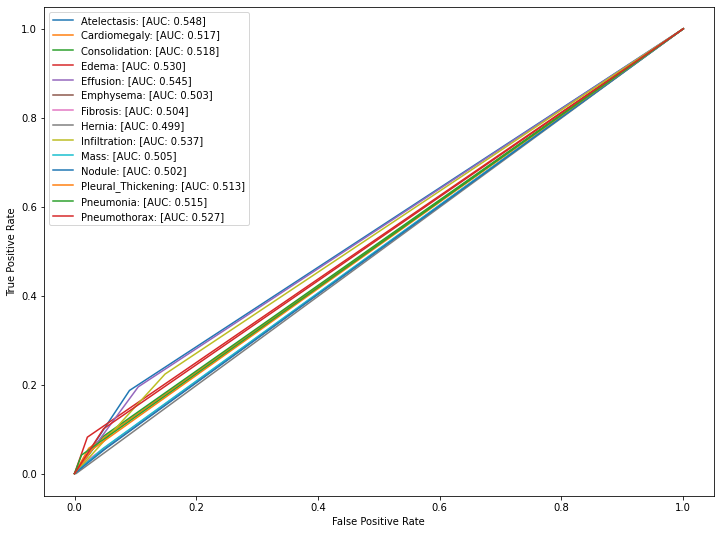

Done!


In [107]:
y_preds2 = dtree.predict(X_test)
auc_dict = plot_roc_curve(class_dict, y_preds2, y_test, get_auc=True)
print("Done!")

In [108]:
# DO NOT USE

from sklearn.metrics import classification_report, accuracy_score

print(classification_report(y_test, y_preds2))
print(accuracy_score(y_test, y_preds2))

              precision    recall  f1-score   support

           0       0.19      0.19      0.19       578
           1       0.06      0.06      0.06       141
           2       0.07      0.08      0.08       232
           3       0.07      0.08      0.08       110
           4       0.19      0.20      0.19       641
           5       0.03      0.03      0.03       149
           6       0.02      0.02      0.02        86
           7       0.00      0.00      0.00         8
           8       0.25      0.22      0.24      1028
           9       0.06      0.06      0.06       286
          10       0.06      0.06      0.06       303
          11       0.05      0.05      0.05       166
          12       0.04      0.04      0.04        72
          13       0.10      0.10      0.10       278

   micro avg       0.15      0.14      0.14      4078
   macro avg       0.09      0.08      0.09      4078
weighted avg       0.15      0.14      0.15      4078
 samples avg       0.06   

E:\ARSH\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\ARSH\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
dtree = DecisionTreeClassifier(random_state=7)
parameters = {'criterion': ["gini", "entropy"], 'max_depth':[50, 75, 100, 125, 150, 200, 300, 500],
             "min_samples_split": [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50], "min_samples_leaf": [1, 5, 10, 15],
             "max_features": ["sqrt", None, "log2"]}

clf = GridSearchCV(dtree, parameters, cv=5, verbose=1)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 2112 candidates, totalling 10560 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
clf.predict(X_train, y_train)

In [ ]:
best_params, best_estimator = clf.best_params, clf.best_estimator

## 3. RANDOM FOREST


In [ ]:
print("Fitting Random Forest Classifier...")
start = time.time()
rfc = RandomForestClassifier(max_features='sqrt',
                             min_samples=1
                             n_estimators=50,
                             random_state=7)
rfc.fit(X_train, y_train)

filepath = r"E:\ARSH\NEU\Fall 2021\CS 5100\Projects\NIH_Disease_Detection\ML Models and Outputs\random_forest_classifier.sav"
save_model(rfc, filepath)

print("Done!")
print("Time Taken: {:.5f}".format(time.time()-start))

In [ ]:
print("Evaluating Model on Test Set...")
y_preds = rfc.predict_proba(X_test)
print("Creating ROC Curve and computing AUC...")
auc_dict = plot_roc_curve(class_dict, y_preds, y_test, get_auc=True)
print("Done!")

In [ ]:
auc_dict

In [17]:
# parameters = {'estimator__penalty': ["l1", "l2", "elasticnet"], 
#               'estimator__solver':["lbfgs", "sag", "saga"]}

In [ ]:
# clf = GridSearchCV(ovr_logistic_regression, parameters, cv=5)
# clf.fit(X_train, y_train)

E:\ARSH\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\ARSH\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\ARSH\Anaconda3\lib\site-packages\sklearn\multiclass.py", line 245, in fit
    for i, column in enumerate(columns))
  File "E:\ARSH\Anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "E:\ARSH\Anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "E:\ARSH\Anaconda3\lib\site-packages\joblib\parallel.py", line 784, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "E:\ARSH\Anaconda3\lib\site-packages\joblib\_parallel_backends